## BRAIN MRI PROJECT

Big Data Project by Mikel Prieto Echegaray & Álvaro Resano Redín

The main objective of this notebook is to perform a CNN model in order to be able to differenciate between several brain tumours.

We have obtained the dataset from Kaggle, url: https://www.kaggle.com/datasets/mohammadhossein77/brain-tumors-dataset

There are 3 types of tumours: glioma, meningioma and pituitary.

Each step of this study will be explained on the notebook.

# 1. Load data

First, we load the data from the url and we set the image size, all the images of the dataset should have this size but we will resize them just in case there is any image with different size.

In [1]:
%run load_data.py

We want to differenciate between the images taken from an axial perspective and the rest of images

Now we transform the data to a PyTorch Dataset

view_tipe="all" --> all images from the dataset

view_tipe="axial" --> images with axial perspective

view_tipe="sagittal" --> rest of the images from the dataset

Not only have we transformed the images to PyTorch, but also:
- resized all images to 224x224
- normalized values to 255
- changed format from (height, width, channel) to (channel, height, width)

We load the dataset

**Count of images per class**

In [2]:
%run plots.py

In [3]:
count_of_classes(brain_dataset)

Imagen guardada como amount_classes.png


**Random Samples Plot**

Samples from all the dataset

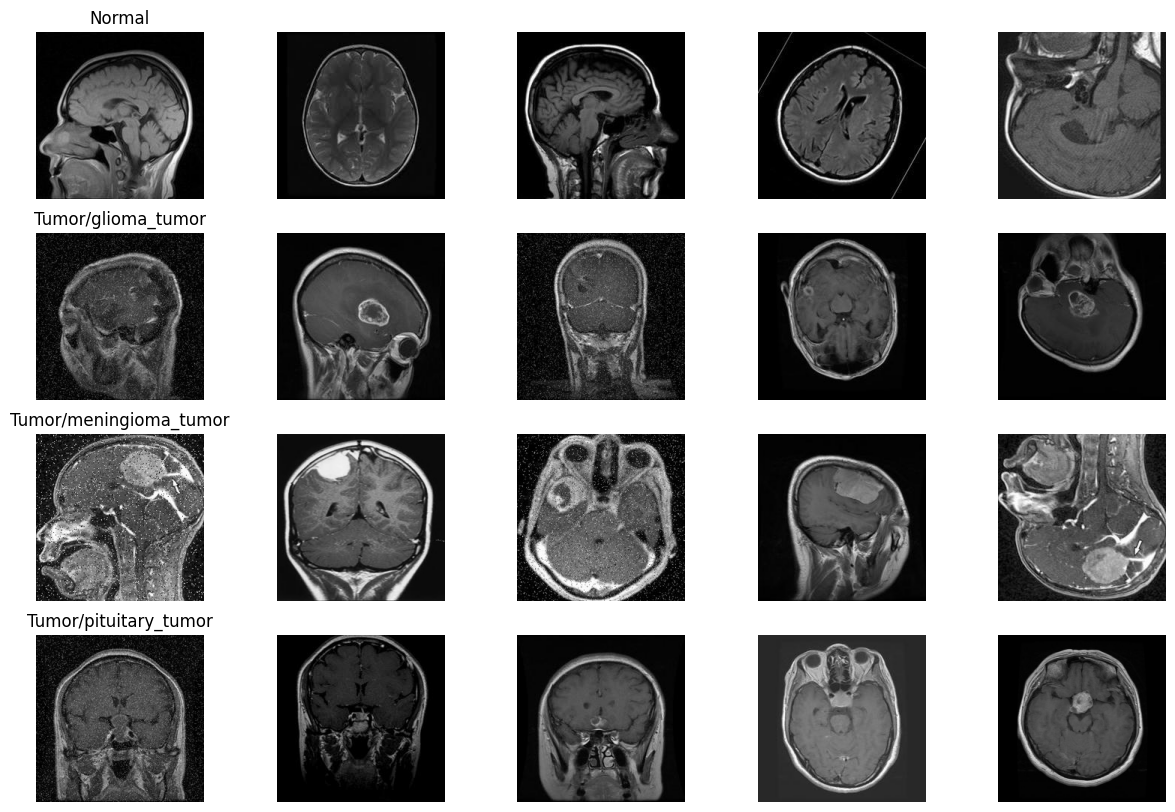

In [4]:
show_random_samples(brain_dataset, brain_dataset.classes)

Samples from axial perspective

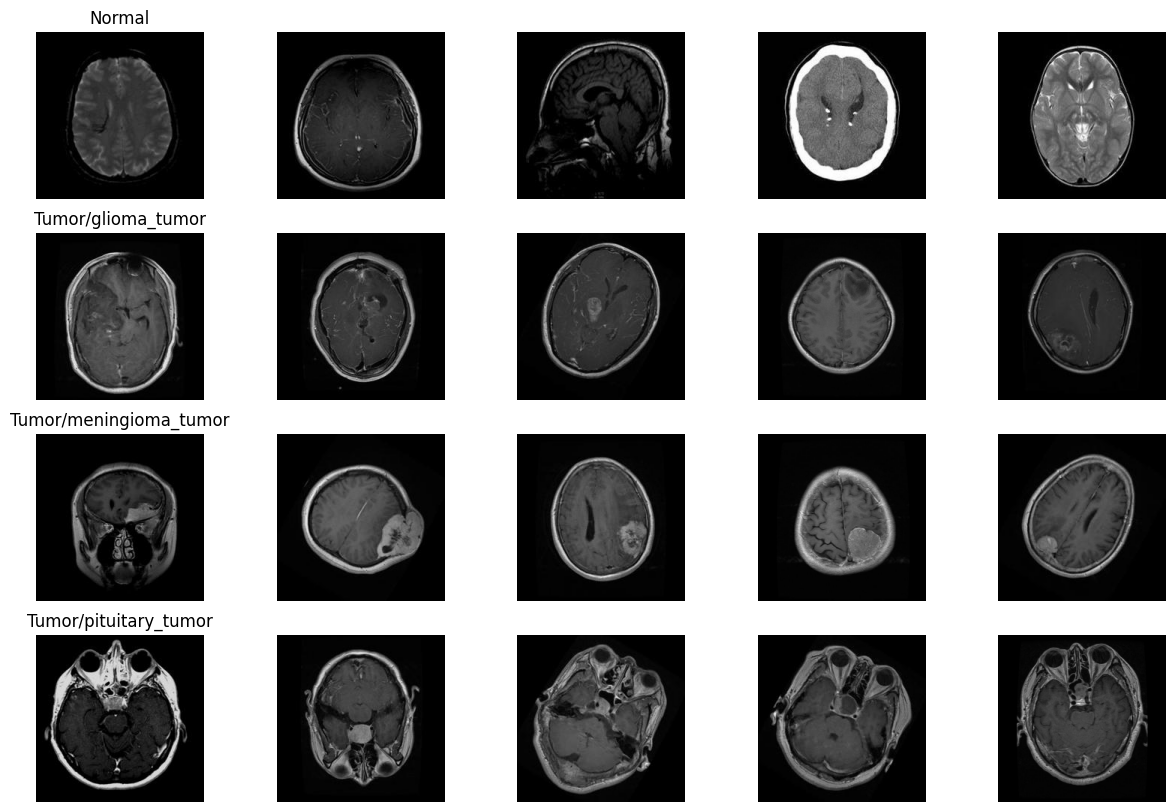

In [5]:
show_random_samples(axial_dataset, axial_dataset.classes)

# 2. Split data in train and test

First, we will set a seed for random functions

In [6]:
%run train_test_split.py

We split data in 80% train and 20% test.
We have stratified the data in order to guarantee the proportion between classes remains 

We will use cuda if it is available instead of the cpu

In [7]:
import torch
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()


# 3. CNN Arquitecture

The next step is to create the Convolutional Neural Network, with 3 convolutional layers, max pooling and 2 fully connected layers. We have also decided to use Dropout for regularization.

In [8]:
%run cnn.py

# 4. Model Training

Now we need to train our model in order to learn from our images and hwo the different tumours are shown on RMIs.

This is the train function we will be performing

In [10]:
%run training.py

First, we create an instance of our model and change it to GPU or CPU.

We use CrossEntropyLoss for multiclass classification.

We use Adam as optimizer with learning rate equal to 0.001.

Finally, we train the model 10 epochs and we save the Loss.

In [11]:
import torch.optim as optim

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.8468
Epoch 2/10, Loss: 0.4546
Epoch 3/10, Loss: 0.2566
Epoch 4/10, Loss: 0.1481
Epoch 5/10, Loss: 0.1106
Epoch 6/10, Loss: 0.0718
Epoch 7/10, Loss: 0.0615
Epoch 8/10, Loss: 0.0518
Epoch 9/10, Loss: 0.0493
Epoch 10/10, Loss: 0.0398


**Training Loss Plot**

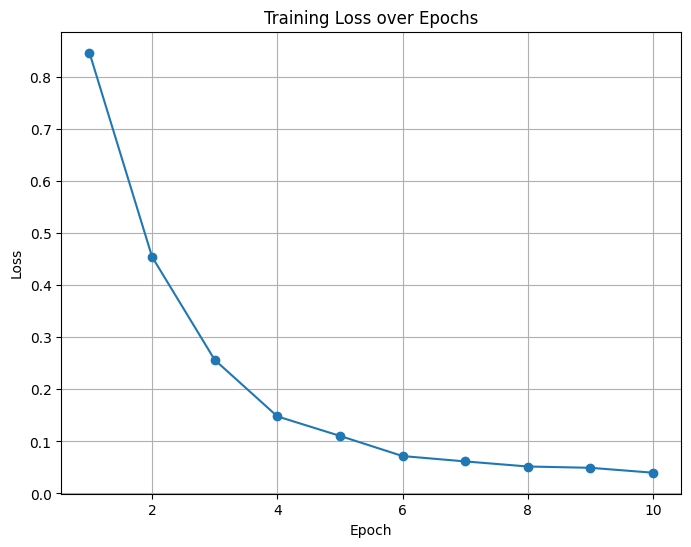

In [12]:
plot_training_loss(history)

The conclusion we obtain based on the Elbow Rule is that it is not necessary to perform 10 epochs for our training, 5 are enough.

**Final Model**

In [13]:
final_model = CNNModel().to(device)
optimizer = optim.Adam(final_model.parameters(), lr=0.001)

train_model(final_model, train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.8643
Epoch 2/5, Loss: 0.4632
Epoch 3/5, Loss: 0.2475
Epoch 4/5, Loss: 0.1431
Epoch 5/5, Loss: 0.0992


{'loss': [0.8642753313718247,
  0.463154691199315,
  0.2475385342645579,
  0.14311800136426772,
  0.09919271316908547]}

**Confusion Matrix Plot**

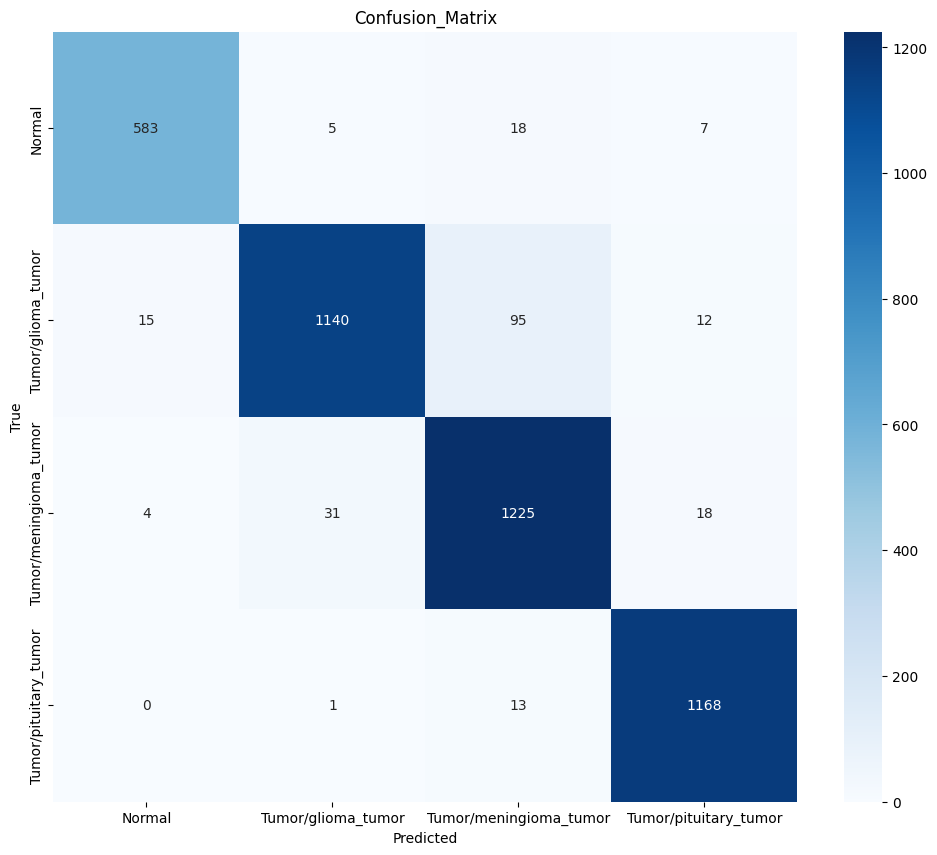

In [14]:
plot_confusion_matrix(final_model, test_loader, brain_dataset.classes)

# 5. Model Evaluation

On this last part of our notebook, we evaluate how our model has performed using standard classification metrics.

In [19]:
%run evaluation.py

In [20]:
evaluate_model(final_model, test_loader)

Accuracy: 94.95%
Precision: 0.9505
Recall: 0.9495
F1 Score: 0.9494


**ROC Curves plot**

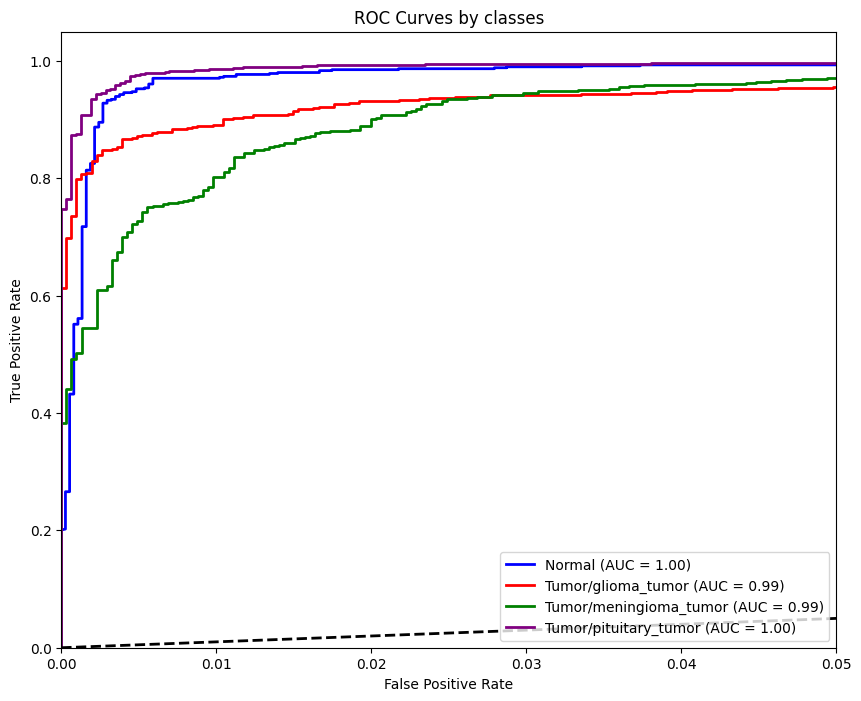

In [21]:
plot_roc_curves(final_model, test_loader, brain_dataset.classes)

# PCA AND MEAN IMAGES FROM AXIAL IMAGES

First we load inly the images from the axial perspective

**MEAN IMAGE**

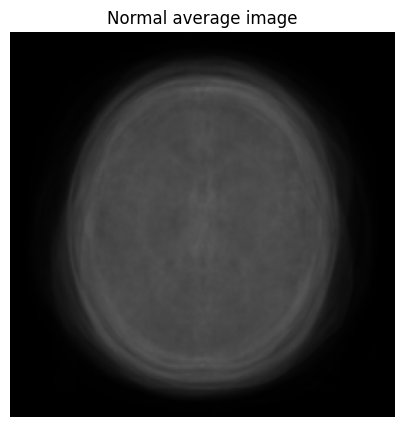

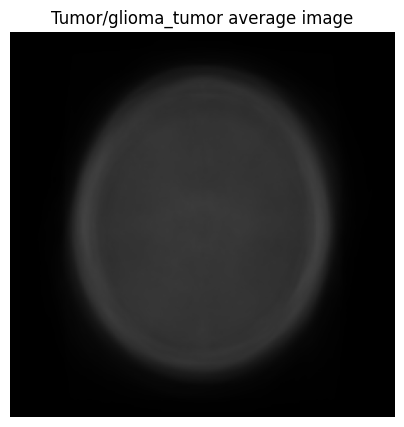

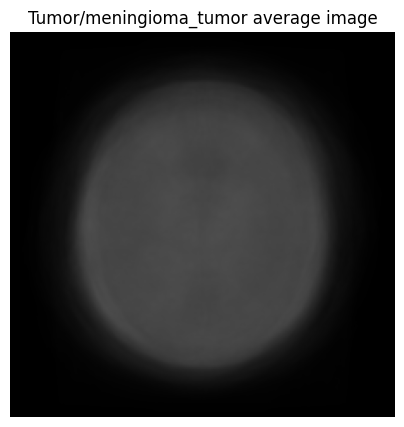

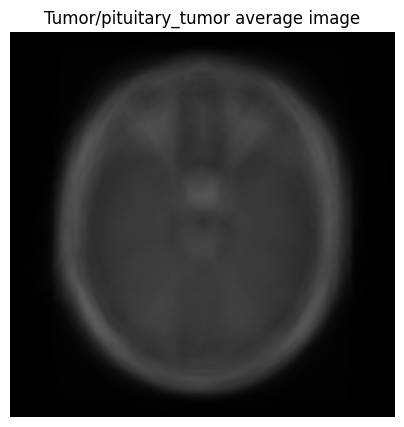

In [37]:
%run mean.py

/home/alvaro/project/BigData/pca_mean.py:44: RuntimeWarning: invalid value encountered in sqrt
  mean_diff = np.sqrt((normal_mean)**2 - (tumor_mean)**2)


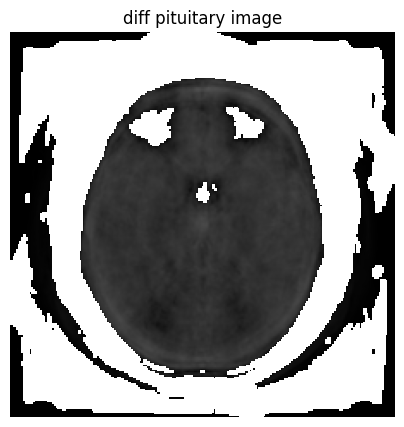

In [34]:
mean_diff(normal_mean, pituitary_mean, "pituitary")

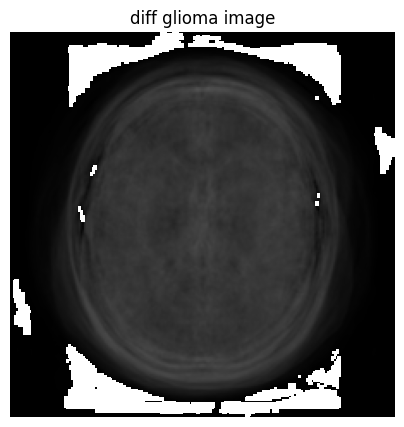

In [35]:
mean_diff(normal_mean, glioma_mean, "glioma")

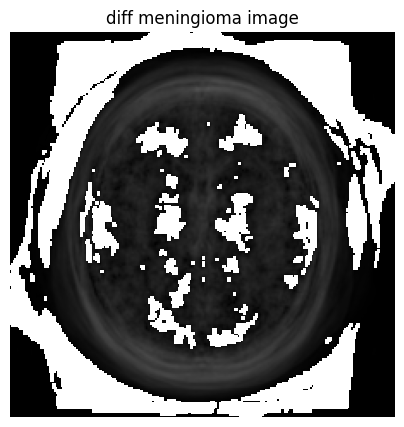

In [36]:
mean_diff(normal_mean, meningioma_mean, "meningioma")

**PCA**

In [39]:
%run pca.py

NameError: name 'images' is not defined

**Visualize 5 first components as images**

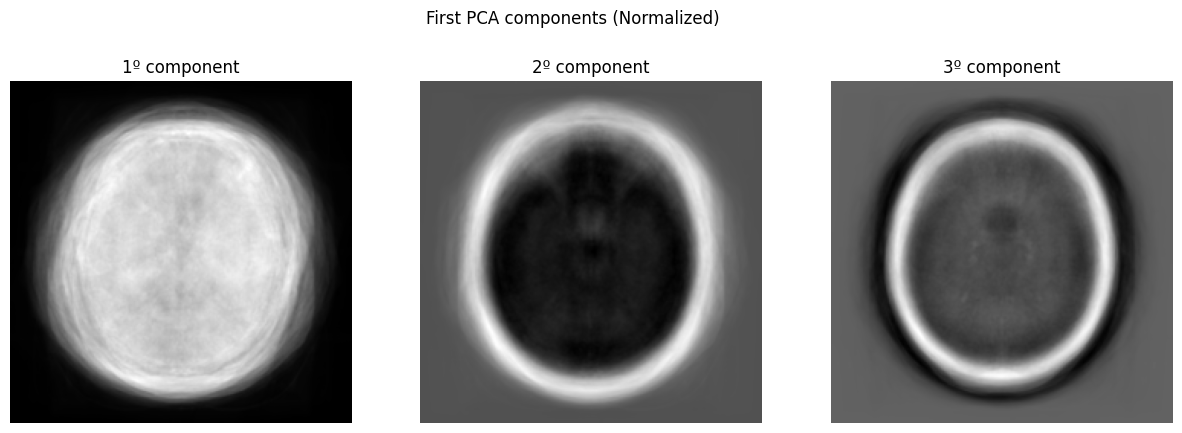

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

# from (N, C, H, W) to (N, C*H*W)
flattened_images = images.reshape(images.shape[0], -1)  # (N, C*H*W)

# Compute PCA
n_components = 50
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(flattened_images)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    component = pca.components_[i].reshape(images.shape[1], images.shape[2], images.shape[3])  # (C, H, W)
    component_img = np.transpose(component, (1, 2, 0))  # (H, W, C)
    
    component_img -= component_img.min()
    component_img /= component_img.max()

    axs[i].imshow(component_img)
    axs[i].axis('off')
    axs[i].set_title(f'{i+1}º component')

plt.suptitle("First PCA components (Normalized)")
plt.show()


  449 images


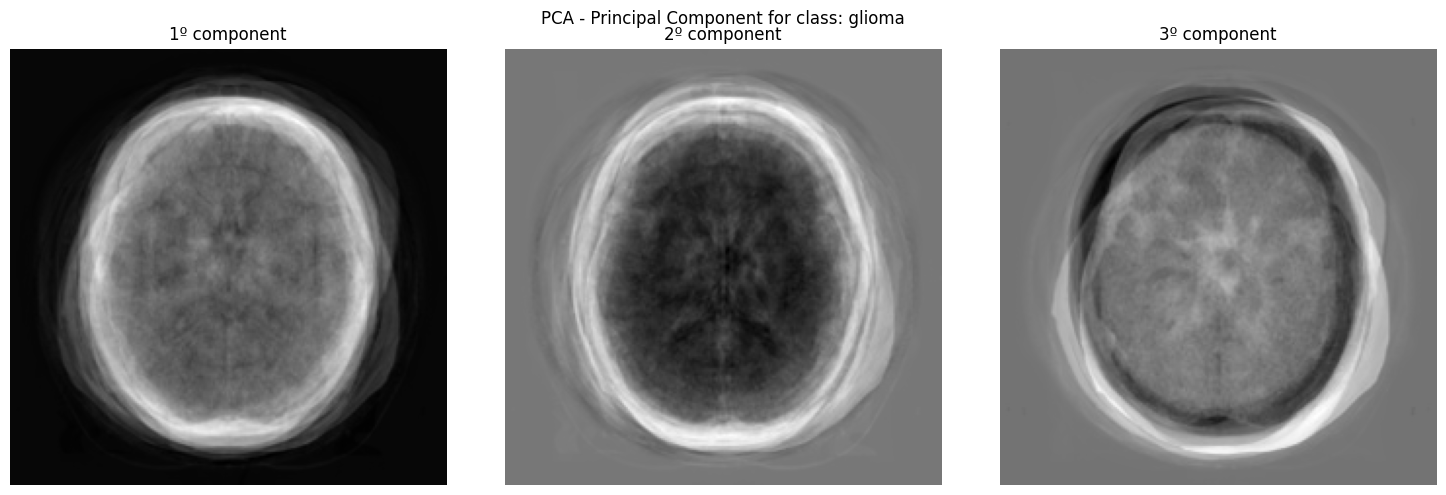

  1606 images


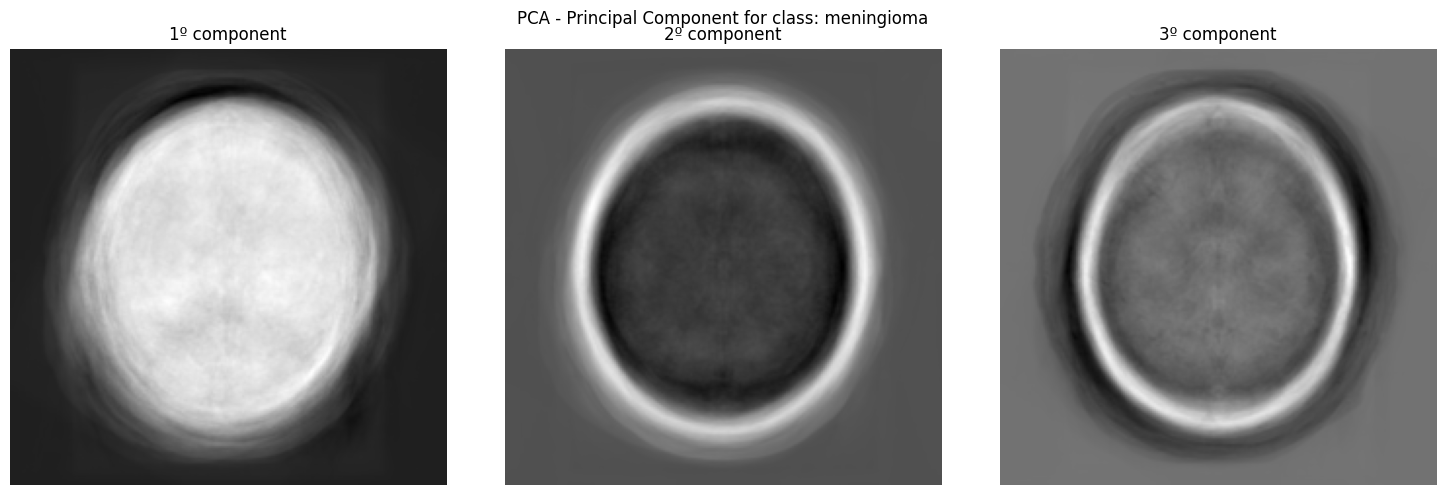

  1183 images


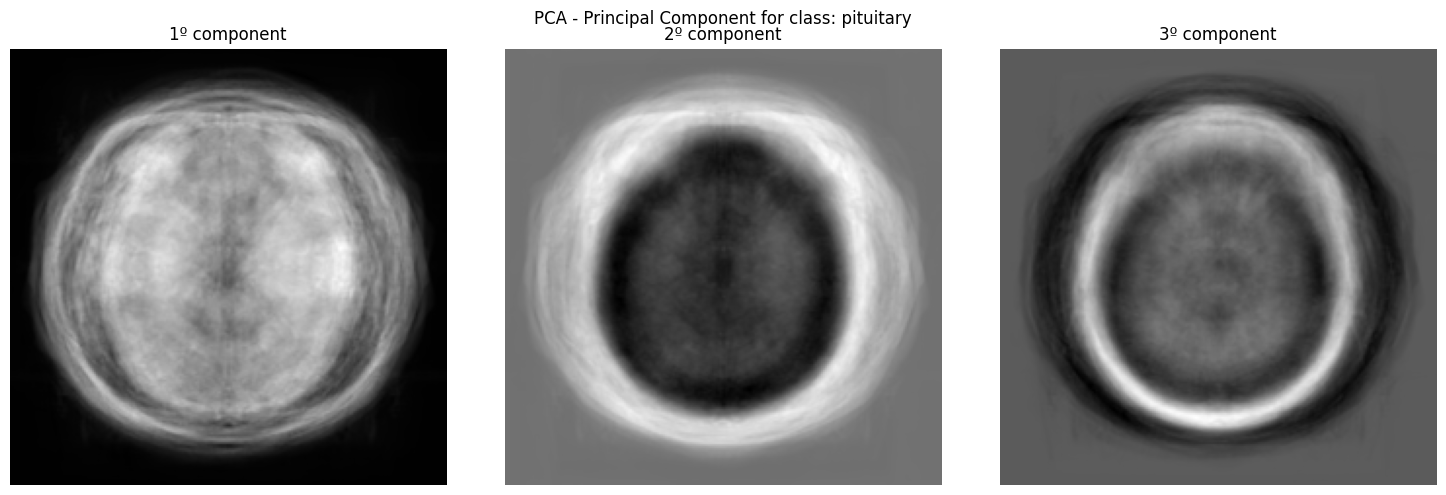

  662 images


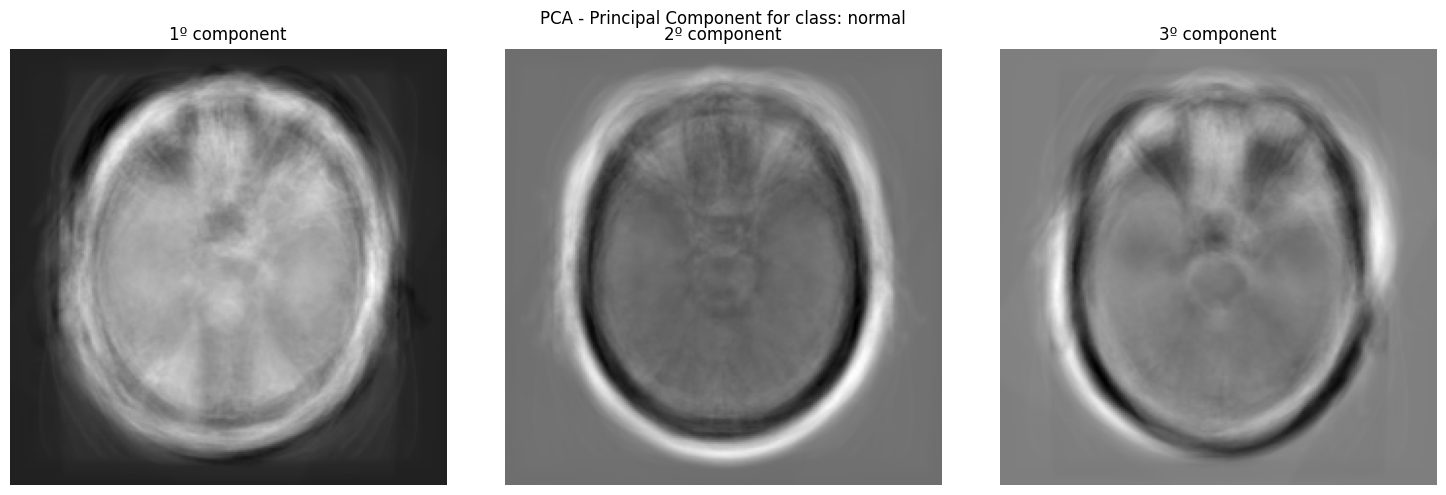

In [ ]:
#(C, H, W)
img_shape = (3, 224, 224)

label_map = {
    0: 'glioma',
    1: 'meningioma',
    2: 'pituitary',
    3: 'normal'
}


for class_id, class_name in label_map.items():
    
    class_images = []
    for img, label in axial_dataset:
        if (label.item() if torch.is_tensor(label) else label) == class_id:
            img_np = img.numpy()
            img_resized = cv2.resize(img_np.transpose(1, 2, 0), (img_shape[2], img_shape[1]))  # (H, W, C)
            img_resized = img_resized.transpose(2, 0, 1)  #(C, H, W)
            class_images.append(img_resized.flatten())

    class_images = np.array(class_images)

    print(f"  {class_images.shape[0]} images")

    # PCA
    pca = PCA(n_components=3)
    pca.fit(class_images)


    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        component = pca.components_[i].reshape(img_shape)  # (C, H, W)
        component_img = np.transpose(component, (1, 2, 0))  # (H, W, C)


        component_img -= component_img.min()
        component_img /= component_img.max()

        axs[i].imshow(component_img)
        axs[i].axis('off')
        axs[i].set_title(f'{i+1}º component')

    plt.suptitle(f"PCA - Principal Component for class: {class_name}")
    plt.tight_layout()
    plt.show()


# PCA AND T-SNE

Data matrix shape: (3900, 150528)


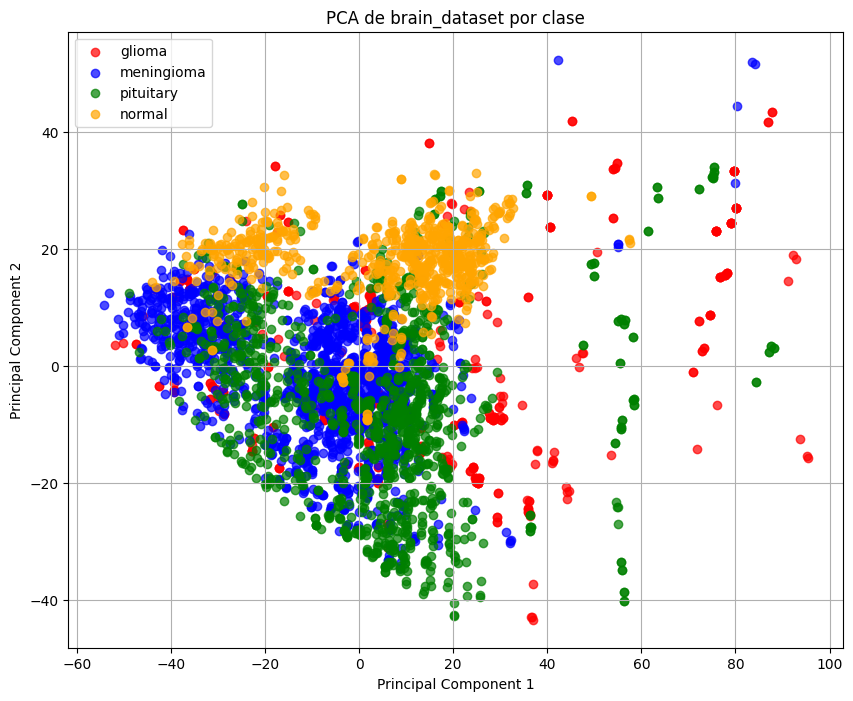

In [ ]:
colors = {
    "glioma": "red",
    "meningioma": "blue",
    "pituitary": "green",
    "normal": "orange"
}

data = []
labels = []

for img, label in axial_dataset:
    img_np = img.numpy().transpose(1, 2, 0)  # from (C, H, W) to (H, W, C)
    resized = cv2.resize(img_np, (224, 224))
    data.append(resized.flatten())
    labels.append(label.item() if torch.is_tensor(label) else label)

data_matrix = np.array(data)
print(f"Data matrix shape: {data_matrix.shape}")

pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_matrix)

# Visualización por clase
plt.figure(figsize=(10, 8))
for class_id, class_name in label_map.items():
    indices = [i for i, lbl in enumerate(labels) if lbl == class_id]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1],
                label=class_name, alpha=0.7, color=colors[class_name])

plt.title("PCA de brain_dataset por clase")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


Data matrix shape: (3900, 150528)


/home/alvaro/bigdata/bigdata/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


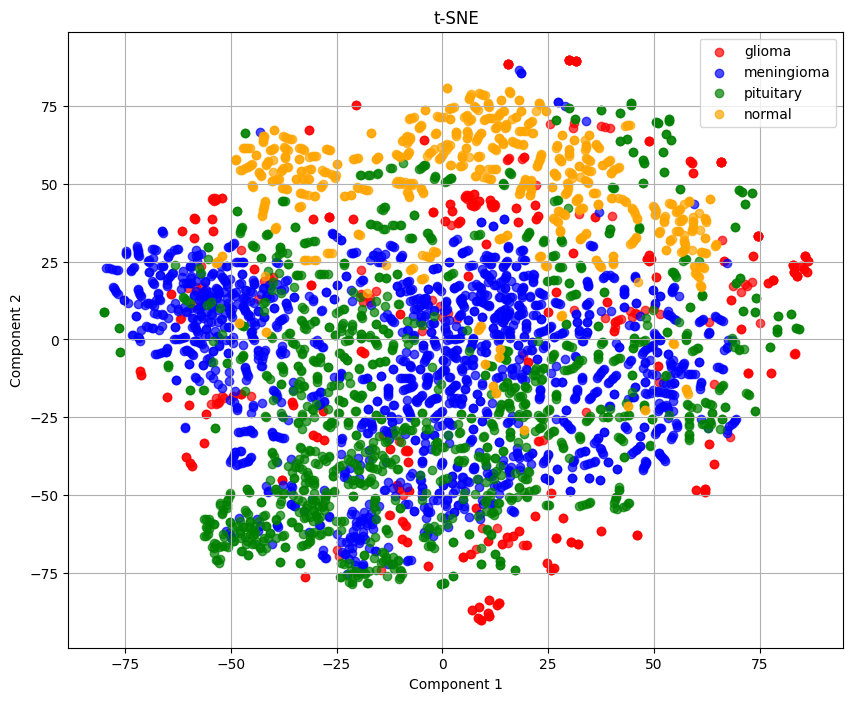

In [ ]:
from sklearn.manifold import TSNE

data = []
labels = []

for img, label in axial_dataset:
    img_np = img.numpy().transpose(1, 2, 0)  # (H, W, C)
    resized = cv2.resize(img_np, (224, 224))
    data.append(resized.flatten())
    labels.append(label.item() if torch.is_tensor(label) else label)

data_matrix = np.array(data)
print(f"Data matrix shape: {data_matrix.shape}")


tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(data_matrix)


plt.figure(figsize=(10, 8))
for class_id, class_name in label_map.items():
    indices = [i for i, lbl in enumerate(labels) if lbl == class_id]
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1],
                label=class_name, alpha=0.7, color=colors[class_name])

plt.title("t-SNE")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()
